In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.signal import butter, lfilter

In [2]:
#Read data from CSV datafile
dataset = pd.read_excel("data.xlsx", usecols=[0,1]) 
array_data = np.array(dataset);
array_data = array_data[:30000]

In [3]:
#x is time, y is RED
x = np.array([i*0.02 for i in range(0,30000)]);
y = array_data[:,1];

In [4]:
#Functions for Butterworth filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
#Filter RED data for Heart Rate (0.5-2 Hz)
y_HR = butter_bandpass_filter(y[:], 0.2, 1.1, 50, order=5)

In [6]:
from scipy.signal import argrelmax, argrelextrema

#Finding the index of peaks for heart rate
peakindex_HR = argrelextrema(y_HR, np.greater)

#Storing the peaks and corresponding times for Heart rate
peaks_HR = [y_HR[i] for i in peakindex_HR]
time_HR = [x[i] for i in peakindex_HR]

In [7]:
#Calculating denominators for Heart Rate formula - distance between two peaks
HR_diff = [peakindex_HR[0][i+1] - peakindex_HR[0][i] for i in range(len(peakindex_HR[0])-1)]
#print HR_diff

#Calculating heart rate
HR_array = []
for i in HR_diff:
    HR_array.append(3000.0/i);    #Instantaneous Heart rate

print "Average Heart Rate: ", np.around(np.mean(HR_array[2:]),4)

HR_range = [elem for elem in np.array(HR_array) if elem > 50 and elem<100]
print "Instantaneous Heart Rate"
#print HR_range
print "Percentage of data considered: ",100*float(len(HR_range))/len(HR_array)
print "Average of range considered: ",np.mean(HR_range)

Average Heart Rate:  68.6528
Instantaneous Heart Rate
Percentage of data considered:  57.4171029668
Average of range considered:  72.6830201075


In [8]:
#Filtering for Respiration rate
y_R = butter_bandpass_filter(y[:], 0.2, 0.5, 50, order=5)

#Finding index of peaks for Respiration rate
peakindex_R = argrelextrema(y_R, np.greater)

#Finding peaks and corresponding times for Respiration rate
peaks_R = [y_R[i] for i in peakindex_R]
time_R = [x[i] for i in peakindex_R]

In [9]:
#print time_R

#Finding respiration rate
R_array = []
R_diff = [time_R[0][i+1] - time_R[0][i] for i in range(len(time_R[0])-1)]
for i in R_diff:
    R_array.append(60/i)    #Instantaneous

print "Instantaneous Respiration Rate: "
#print np.around(R_array[1:],4)    
#Average
print "Average respiration rate: ", np.around(np.mean(R_array[1:]),4)

Instantaneous Respiration Rate: 
Average respiration rate:  17.1845


In [10]:
#SPO2 calculation

#Already calculated max peaks for RED (peaks_HR, time_HR)
#Applying filter
upper = 1.5
order = 2
y_RED = butter_bandpass_filter(y[:], 0.001, upper, 50, order)

#Finding index of peaks for RED
peakindex_RED = argrelextrema(y_RED, np.greater)

#Calculating peaks and corresponding times for RED
peaks_RED = [y_RED[i] for i in peakindex_RED]
time_RED = [x[i] for i in peakindex_RED]

#Finding min peaks index for RED
peakindex_RED_min = argrelextrema(y_RED, np.less)
peaks_RED_min = [y_RED[i] for i in peakindex_RED_min]
time_RED_min = [x[i] for i in peakindex_RED_min]

In [11]:
#Interpolating min peaks for RED to find DC at time_HR
DC_RED = np.interp(time_RED[0], time_RED_min[0], peaks_RED_min[0])

#Calculating AC for RED values
AC_RED = peaks_RED[0] - DC_RED

In [12]:
#z is IR values
z = array_data[:,0];

#Applying filter
z_IR = butter_bandpass_filter(z[:], 0.001, upper, 50, order)

#Finding index of peaks for IR
peakindex_IR = argrelextrema(z_IR, np.greater)

#Calculating peaks and corresponding times for IR
peaks_IR = [z_IR[i] for i in peakindex_IR]
time_IR = [x[i] for i in peakindex_IR]

#Finding index of min peaks for IR
peakindex_IR_min = argrelextrema(z_IR, np.less)

#Finding peaks and corresponding times for min IR peaks
peaks_IR_min = [z_IR[i] for i in peakindex_IR_min]
time_IR_min = [x[i] for i in peakindex_IR_min]

In [13]:
#Interpolating min peaks for RED to find DC at time_IR
DC_IR = np.interp(time_IR[0], time_IR_min[0], peaks_IR_min[0])

#Calculating AC for IR values
AC_IR = peaks_IR[0] - DC_IR

In [14]:
#Calculating ratio average
#Finding if RED/ IR has lesser number of peaks
length = 0
if len(AC_RED) < len(DC_IR):
    length = len(AC_RED)
else:
    length = len(DC_IR)
        
num = AC_RED[0:length]*DC_IR[0:length]
den = AC_IR[0:length]*DC_RED[0:length]

ratio_avg = num/den
#ratio_avg = den/num

In [15]:
spo2 = -45.060*ratio_avg*ratio_avg+30.354*ratio_avg+94.845

spo2_range = [elem for elem in np.array(spo2) if elem > 90 and elem < 100]
print "Instantanoues SPO2: "
#print spo2_range
print "Percentage of data considered: ",100*float(len(spo2_range))/len(spo2)
print "Average of SPO2 considered: ",np.mean(spo2_range)

Instantanoues SPO2: 
Percentage of data considered:  55.2112676056
Average of SPO2 considered:  97.2570574689


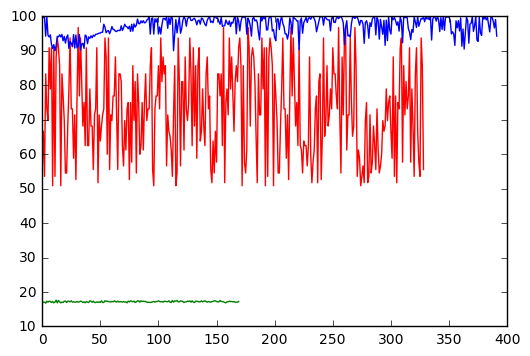

In [16]:
x_range = [i for i in range(len(HR_range))]
plt.plot(x_range, HR_range, 'r')

x_range = [i for i in range(len(R_array)-1)]
plt.plot(x_range, R_array[1:], 'g')

x_range = [i for i in range(len(spo2_range))]
plt.plot(x_range, spo2_range, 'b')

plt.show()